In [26]:
from zipfile import ZipFile
from ast import literal_eval
from IPython.display import Image, display
import re
import pandas as pd
import pytesseract
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
datadf = pd.read_csv('All Data/Raw Journey Data/Until16May2020(all jsons to csv).csv')
datadf.rename(columns={'Unnamed: 0':'id'}, inplace=True)
datadf.set_index('id', inplace=True)
datadf.head(2)

,text,date_modified,date_journal,address,lat,lon,posture,timezone,favourite,weather,photos,tags,no_punc,is_personal,cleaned_text
id,,,,,,,,,,,,,,,
1439137473084-3fc756cc3f8d6404,"The first thing I saw ,when I entered her room...",2017-08-31 01:44:57,2015-08-09 11:24:33,NaN,1.7976931348623157e+308,1.7976931348623157e+308,0,NaN,False,"{'id': -1, 'degree_c': 1.7976931348623157e+308...",[],"['personal', 'published']",The first thing I saw when I entered her room ...,1,"The first thing I saw , when I entered her roo..."
1439198245820-3fda14add91e3f20,Philosophy\n\n\n\n\n\n\nIt surprises me..hw u ...,2017-08-22 22:08:05,2015-08-10 04:17:25,NaN,1.7976931348623157e+308,1.7976931348623157e+308,0,NaN,False,"{'id': -1, 'degree_c': 1.7976931348623157e+308...",[],['personal'],Philosophy It surprises me hw u so effortlessl...,1,Philosophy It surprises me ... hw you so effor...


In [4]:
# for i in range(len(text_from_images)):  
#     for each in re.findall(r".{47}.jpg",text_from_images.photos[i]):
#         try:
#             path = 'All Data/Raw Journey Data/Until16May2020(no HQ media)/'+each
# #             text_from_images['text_image'][i] = pytesseract.image_to_string(path)
#         except:
#             pass
    

In [5]:
home_path = 'All Data/Raw Journey Data/Until16May2020(no HQ media)/'
images = []
for filename in os.listdir(home_path):
    if filename.endswith('.jpg'):
        images.append(filename)

In [6]:
images = pd.DataFrame(images).rename(columns={0:'image_name'})

In [7]:
images

,image_name
0,1543208521055-3fd9ea85cb5b929a-3fe781148bf7bc9...
1,1588354752808-3fecfbbe72fd40d4-3fda19fb3b16945...
2,1558470258298-3fe056157ea11b59-3fdb582e8224a20...
3,1581785142356-3fd0f489ebeb98cc-3fca8c84f27dd6d...
4,1523113867241-3fe35c12e18113a2-3fdada3afaad314...
...,...
2104,1588780268789-3fe9a7e467669373-3fd0fddd022b9ff...
2105,1582242709998-3fec42df16c6b008-3fcbe24357e983b...
2106,1475832629340-3feed134040812d1-3fcb69aa220f411...
2107,1571356580582-3fb1bc122a8cacd8-3fd22d0d65af4ce...


In [8]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

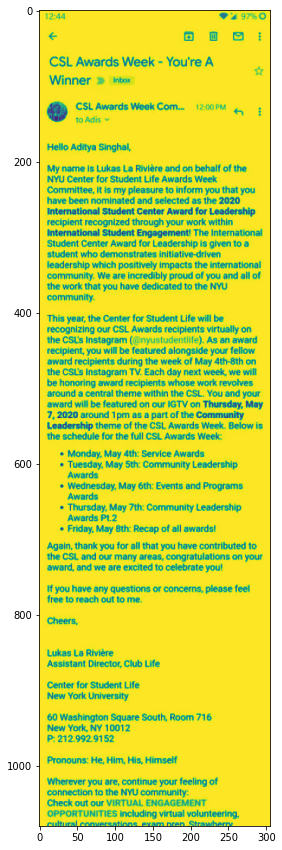

In [33]:
img = cv2.imread(home_path+images.image_name[1])

plt.figure(figsize=(35,15))
plt.imshow(get_grayscale(img))

In [35]:
print(pytesseract.image_to_string(home_path+images.image_name[1]))

2:44 4970
€ ooee8

CSL Awards Week - You're A
Winner ® into«

CSL Awards Week Com... 200M

Hello Aditya Singhal,

‘My name is Lukas La Riviere and on behalf of the
NYU Center for Student Life Awards Week
Committee, itis my pleasure to inform you that you
hhave been nominated and selected as the 2020
International Student Center Award for Leadership
recipient recognized through your work within
International Student Engagement! The International
Student Center Award for Leadership Is given to a
student who demonstrates intiative-driven
leadership which positively impacts the international
‘community. We are incredibly proud of you and all of
the work that you have dedicated to the NYU
‘community

This year, the Center for Student Life will be
recognizing our CSL Awards recipients virtually on
the CSt's Instagram (@nyustudentlfe). As an award
recipient, you will be featured alongside your fellow
award recipients during the week of May 4th-8th on.
the CSU's Instagram TV. Each day next wee